# Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    make_scorer,
    roc_auc_score,
    roc_curve, 
    auc
)
from xgboost import XGBClassifier

import sys,os
notebook_path = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_root)

from utils.ml_tools import train_model, model_evaluation, find_optimal_threshold

In [2]:
np.random.seed(42)

## Import data

In [3]:
data = pd.read_csv('../data/cleaned_engineered_data.csv')

In [4]:
X = data.drop(columns=['Churn'])
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Baseline

This analysis implements a contract-based heuristic baseline for churn prediction, leveraging the relationship between customer contract duration and churn behavior. The approach uses data-driven thresholds rather than simple rule-based predictions

In [5]:
import plotly.express as px
contract_churn_rates = {}
for contract_type in ['Month-to-month', 'One year', 'Two year']:
    if f'Contract_{contract_type}' in X_train.columns:
        mask = X_train[f'Contract_{contract_type}'] == 1
        churn_rate = y_train[mask].mean()
        contract_churn_rates[contract_type] = churn_rate
        print(f"{contract_type} churn rate: {churn_rate:.3f}")

# Use the churn rates to set thresholds
# Predict churn if customer has contract type with churn rate > threshold
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for t in thresholds:
    preds = np.zeros(len(X_test))
    
    for contract_type, churn_rate in contract_churn_rates.items():
        if churn_rate > t and f'Contract_{contract_type}' in X_test.columns:
            mask = X_test[f'Contract_{contract_type}'] == 1
            preds[mask] = 1
    
    f1 = f1_score(y_test, preds)
    f1_scores.append(f1)

fig = px.line(
    x=thresholds,
    y=f1_scores,
    labels={"x": "Churn Rate Threshold", "y": "F1 Score"},
    title="Contract-based Heuristic Baseline: Threshold vs F1 Score"
)
fig.show()

print(f"Best Contract F1 Score: {max(f1_scores):.3f}")

Month-to-month churn rate: 0.427
One year churn rate: 0.111
Two year churn rate: 0.029


Best Contract F1 Score: 0.574


Baseline Achievement:
- Best F1 Score: 0.574
- Optimal Threshold: 0.424

Implications:
- This suggests Contract type has significant predictive power for churn
- The optimal threshold lower than standard (0.5) indicates that churn class is less frequent than non-churn

## Model training

In [6]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [7]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
results = {}

for name, model in models.items():
    
    results[name] = train_model(name, model, X_train, y_train)

# Select best model based on ROC AUC (you can change this criterion)
best_model_name = max(results.keys(), key=lambda x: results[x]['cv_roc_auc'])
best_model = results[best_model_name]['model']
best_scores = results[best_model_name]

print(f"Selected: {best_model_name}")
print(f'ROC AUC (avg 5-fold): {best_scores["cv_roc_auc"]:.4f}')
print(f'F1 Score (avg 5-fold): {best_scores["cv_f1"]:.4f}')

Logistic Regression:
  ROC AUC: 0.8488 ± 0.0142
  F1:      0.5922 ± 0.0263
  Precision: 0.6657
  Recall:    0.5338

Random Forest:
  ROC AUC: 0.8096 ± 0.0113
  F1:      0.5347 ± 0.0129
  Precision: 0.6037
  Recall:    0.4803



/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[17:59:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[17:59:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[17:59:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[17:59:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBoost:
  ROC AUC: 0.8161 ± 0.0122
  F1:      0.5513 ± 0.0212
  Precision: 0.5937
  Recall:    0.5151

Selected: Logistic Regression
ROC AUC (avg 5-fold): 0.8488
F1 Score (avg 5-fold): 0.5922


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[17:59:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Observations
- Logistic Regression model yields the best performance initially, achieving ROC AUC score of 0.8488, and F1 score of 0.5922

Insights
- The F1 score is only slightly better than  heuristic baseline of 0.574, which suggests there's room for improvement in precision/recall balance
- The gap between your ROC AUC (0.8488) and F1 score (0.5922) indicates that:
    - The model is good at ranking predictions (ROC AUC) But there might be issues with the **classification threshold** or **class imbalance**

### Logistic regression

#### Hyperparameter tuning

In [9]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  
    'class_weight': [None, 'balanced']
}

scoring = {'f1': make_scorer(f1_score), 'roc_auc': 'roc_auc'}

# Perform grid search
grid_search = GridSearchCV(results['Logistic Regression']['model'], param_grid, cv=cv_strategy, scoring=scoring, refit='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score from CV:", grid_search.best_score_)

lr_model = grid_search.best_estimator_

Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best F1 Score from CV: 0.6379154906361695


Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best F1 Score from CV: 0.6379154906361695


In [10]:
# 3. Threshold optimization using training data
# Method 1: Using a validation split from training data
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, 
                                                          test_size=0.2, 
                                                          random_state=42, 
                                                          stratify=y_train)

# Fit on sub-training data
lr_model.fit(X_train_sub, y_train_sub)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='saga')

In [11]:
y_val_proba = lr_model.predict_proba(X_val)[:, 1]
# Find optimal thresholds using different metrics
metrics = ['f1', 'precision', 'recall']
optimal_thresholds = {}

for metric in metrics:
    threshold, score, all_thresholds, all_scores = find_optimal_threshold(
        y_val, y_val_proba, metric)
    optimal_thresholds[metric] = {
        'threshold': threshold,
        'score': score,
        'all_thresholds': all_thresholds,
        'all_scores': all_scores
    }
    print(f"Optimal threshold for {metric}: {threshold:.3f} (score: {score:.4f})")

Optimal threshold for f1: 0.550 (score: 0.6529)
Optimal threshold for precision: 0.880 (score: 0.9149)
Optimal threshold for recall: 0.100 (score: 0.9933)


#### Evaluate model

In [12]:
res = model_evaluation(lr_model, X_train, y_train, X_test, y_test, threshold=0.55)

=== PHASE 1: COMPREHENSIVE MODEL EVALUATION ===
1. 📊 TRAINING vs TEST PERFORMANCE
Training F1:    0.6408
Test F1:        0.6296
F1 Difference:  0.0112 ✅

Training ROC:   0.8506
Test ROC:       0.8456
ROC Difference: 0.0050

2. 🎯 BASELINE COMPARISON
Baseline F1:        0.5740
Your Model F1:      0.6296
Improvement:        +0.0556 (+9.7%)

3. 📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.89      0.79      0.84      1035
       Churn       0.56      0.73      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409


4. 🔍 CONFUSION MATRIX ANALYSIS
True Negatives (Correct No-Churn):  817
False Positives (Wrong Churn):      218
False Negatives (Missed Churn):     102
True Positives (Correct Churn):     272

Churn Capture Rate: 72.7% (How many churners did we catch?)
Precision Rate:     55.5% (How accurate are 

In [13]:
lr_performance = pd.DataFrame(['Linear Regression', res['train_f1'], res['train_roc_auc'], res['test_f1'], res['test_roc_auc']]).transpose()
lr_performance.columns = ['Model', 'Training F1', 'Training ROC AUC', 'Test F1', 'Test ROC AUC']
lr_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC
0,Linear Regression,0.640816,0.850588,0.62963,0.845615


In [14]:
feature_importance = pd.Series(lr_model.coef_[0], index=X_test.columns).sort_values(ascending=False)
print(feature_importance.head(10))

ChargePerMonthRatio            0.577743
Contract_Month-to-month        0.514385
InternetService_Fiber optic    0.288705
M2M_ElectronicCheck            0.261746
PaperlessBilling               0.235819
Fiber_NoTechSupport            0.232308
Senior_Contract                0.226008
FiberOptic_StreamingTV         0.220416
StreamingMovies                0.182003
MultipleLines                  0.136801
dtype: float64


Key Takeaways
- ChargePerMonthRatio is the most influential predictor, suggesting that how much a customer pays relative to their average or base charge is a strong churn indicator.
- Month-to-month contracts are highly associated with churn, aligning with common behavior where customers without long-term commitment are more likely to leave.
- Fiber optic internet and Electronic Check payment are linked with higher churn risks — these services or methods may be pain points
- Paperless billing also shows a positive correlation with churn, potentially reflecting lower engagement or tech-savvy customers who churn more.
- Features involving fiber users with no tech support or streaming services contribute to churn, suggesting dissatisfaction when support or services are lacking.
- Senior citizens on contracts and streaming habits are meaningful, possibly showing age-based behavior patterns.
- Multiple lines has lower importance but still contributes slightly.

Implications: Focus churn reduction efforts on:
- Users with high relative monthly charges
- Those on month-to-month plans
- Users with fiber optic service but no tech support or added services
- Customers using electronic check payment
- Users with paperless billing, as they may be less engaged

## Random Forest

In [15]:
rf_model = results['Random Forest']['model']

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,
    cv=cv_strategy,
    scoring=scoring,
    refit='f1',
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best F1 Score from CV:", random_search.best_score_)

rf_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Best F1 Score from CV: 0.6404470958004849


In [16]:
y_val_rf_proba = rf_model.predict_proba(X_val)[:,1]
threshold, score, _, _ = find_optimal_threshold(y_val, y_val_proba, metric='f1')

In [17]:
print(threshold)
print(score)

0.5499999999999998
0.6529411764705882


In [18]:
rf_res = model_evaluation(rf_model, X_train, y_train, X_test, y_test, threshold=threshold)

=== PHASE 1: COMPREHENSIVE MODEL EVALUATION ===
1. 📊 TRAINING vs TEST PERFORMANCE
Training F1:    0.7038
Test F1:        0.6247
F1 Difference:  0.0791 ⚠️ Possible overfitting

Training ROC:   0.9023
Test ROC:       0.8423
ROC Difference: 0.0600

2. 🎯 BASELINE COMPARISON
Baseline F1:        0.5740
Your Model F1:      0.6247
Improvement:        +0.0507 (+8.8%)

3. 📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.89      0.79      0.84      1035
       Churn       0.55      0.72      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.78      1409


4. 🔍 CONFUSION MATRIX ANALYSIS
True Negatives (Correct No-Churn):  819
False Positives (Wrong Churn):      216
False Negatives (Missed Churn):     106
True Positives (Correct Churn):     268

Churn Capture Rate: 71.7% (How many churners did we catch?)
Precision Rate:     55

In [19]:
rf_performance = pd.DataFrame(['Random Forest', rf_res['train_f1'], rf_res['train_roc_auc'], rf_res['test_f1'], rf_res['test_roc_auc']]).transpose()
rf_performance.columns = ['Model', 'Training F1', 'Training ROC AUC', 'Test F1', 'Test ROC AUC']
rf_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC
0,Random Forest,0.70378,0.902256,0.624709,0.842303


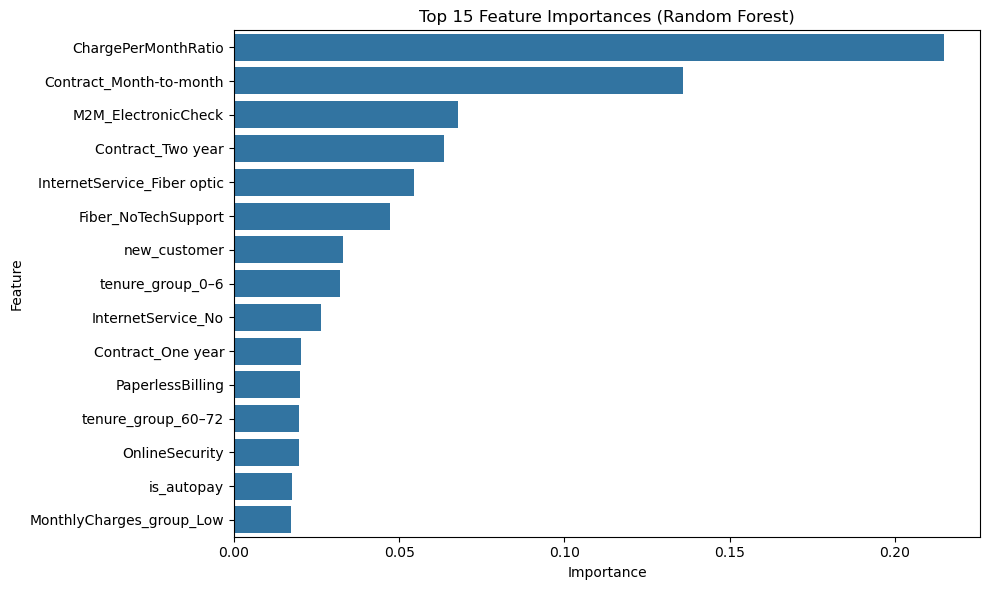

In [20]:
# Get feature importances from RF model
importances = rf_model.feature_importances_
feat_names = X_train.columns

# Create DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x="Importance", y="Feature")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

### XGBoost

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 1.5, 2.0],
    'reg_alpha' : [0, 0.1, 0.5]
}

xgb_random = RandomizedSearchCV(
    estimator=results['XGBoost']['model'],
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)

print("Best Parameters:", xgb_random.best_params_)
print("Best F1 Score from CV:", xgb_random.best_score_)

xgb = xgb_random.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:00:00] WARNING: /Users/runner/work/xgboost/

Best Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.8}
Best F1 Score from CV: 0.5953972171278199


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[18:00:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




In [22]:
xgb_y_val_proba = xgb.predict_proba(X_val)[:, 1]
xgb_threshold, xgb_score, _, _ = find_optimal_threshold(y_val, xgb_y_val_proba, metric='f1')
print(xgb_threshold)
print(xgb_score)

0.33999999999999986
0.6717095310136157


In [23]:
xgb_res = model_evaluation(xgb, X_train, y_train, X_test, y_test, threshold=xgb_threshold)

=== PHASE 1: COMPREHENSIVE MODEL EVALUATION ===
1. 📊 TRAINING vs TEST PERFORMANCE
Training F1:    0.6454
Test F1:        0.6338
F1 Difference:  0.0116 ✅

Training ROC:   0.8588
Test ROC:       0.8452
ROC Difference: 0.0136

2. 🎯 BASELINE COMPARISON
Baseline F1:        0.5740
Your Model F1:      0.6338
Improvement:        +0.0598 (+10.4%)

3. 📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.89      0.80      0.84      1035
       Churn       0.56      0.72      0.63       374

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.79      1409


4. 🔍 CONFUSION MATRIX ANALYSIS
True Negatives (Correct No-Churn):  827
False Positives (Wrong Churn):      208
False Negatives (Missed Churn):     104
True Positives (Correct Churn):     270

Churn Capture Rate: 72.2% (How many churners did we catch?)
Precision Rate:     56.5% (How accurate are

In [24]:
xgb_performance = pd.DataFrame(['XGBoost', xgb_res['train_f1'], xgb_res['train_roc_auc'], xgb_res['test_f1'], xgb_res['test_roc_auc']]).transpose()
xgb_performance.columns = ['Model', 'Training F1', 'Training ROC AUC', 'Test F1', 'Test ROC AUC']
xgb_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC
0,XGBoost,0.645449,0.858797,0.633803,0.84516


In [25]:
models_performance = pd.concat([lr_performance, rf_performance, xgb_performance])

In [26]:
models_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC
0,Linear Regression,0.640816,0.850588,0.62963,0.845615
0,Random Forest,0.70378,0.902256,0.624709,0.842303
0,XGBoost,0.645449,0.858797,0.633803,0.84516
